Dnes budeme pracovat s neuronovými sítěmi! Začneme s jednoduchými modely, které jste viděli na přednášce: perceptron a multilayer perceptron (MLP). 

# Perceptron

Implementace perceptronového algoritmu je jednoduchá - parametry jsou jen jeden vektor a adaptační pravidlo je také jednoduché.
Navrhneme rozhraní perceptronu tak, aby mělo stejné API jako modely ve scikit-learnu - tj. parametry se nastaví v konstruktoru a třída bude mít dvě metody - `fit(X, y)` a `predict(X)`.

Použijeme maticovou notaci - váženou sumu spočítáme jako skalární součin. Tohle (spolu s použitím knihovny `numpy`) zjednoduší implementaci a zrychlí samotný algoritmus.

In [13]:
import numpy as np

class Perceptron:
    
    def __init__(self, lr, max_iter=100):
        self.lr = lr  # learning rate
        self.max_iter = max_iter
        
    def fit(self, train_X, train_y):
        train_x = np.array(train_X)
        train_x = self._add_ones(train_x)
        self.w_ = np.zeros(train_x.shape[1])
        
        for _ in range(self.max_iter):
            for x,y in zip(train_x, train_y):
                y_hat = self.predict(x, add_ones=False)  # ones were already added before
                self.w_ = self.w_ + self.lr * (y - y_hat) * x
        
    def predict(self, X, add_ones=True):
        x = np.array(X)
        if add_ones:
            x = self._add_ones(x)
        
        return (np.sign(np.dot(x, self.w_.T)) + 1) / 2 # sign -1 or 1 -> change to 0 or 1
    
    def _add_ones(self, x): # add a column of 1s instead of bias
        ones = np.ones(shape=(x.shape[0],1))
        x = np.append(ones,x, axis=1)        
        return x

Pro otestování třídy si náhodně vygenerujeme data. Použijeme jednoduché generátory dat ze scikit-learnu. Vytvoříme data ze dvou (klasifikačních) tříd. Povšimněte si, že výsledky se liší podle toho, jestli jsou obě třídy lineárně separovatelné.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

# simple method to visualize the decision boundary of the model, later we will also use it for one-hot encoding
def draw_boundary(model, X, y, one_hot=False):
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    if one_hot:
        Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(12,8))
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.show()

In [29]:
x, y = np.meshgrid([1,2,3], [3,4,5])  # generates a grid ... cartesian product
print(x.ravel())  # ravel is like flatten, but does not copy the data (only a "view")
print(y.ravel())
np.c_[x.ravel(), y.ravel()]  # c_ is concat

[[1 2 3]
 [1 2 3]
 [1 2 3]] [[3 3 3]
 [4 4 4]
 [5 5 5]]
[1 2 3 1 2 3 1 2 3]
[3 3 3 4 4 4 5 5 5]


array([[1, 3],
       [2, 3],
       [3, 3],
       [1, 4],
       [2, 4],
       [3, 4],
       [1, 5],
       [2, 5],
       [3, 5]])

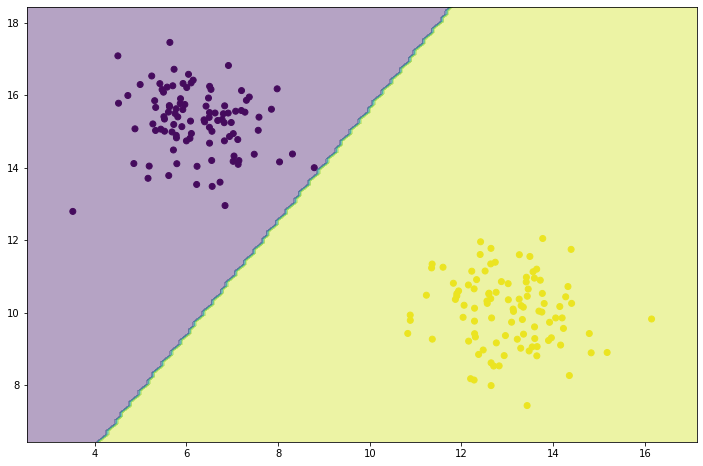

In [35]:
from sklearn import datasets

# try running this cell multiple times to see the difference between separable vs non-separable data 
X, y = datasets.make_blobs(centers=2, n_samples=200)

X += (10,10)

perc = Perceptron(0.1, 1000)
perc.fit(X, y)
draw_boundary(perc, X, y)

# Multi-layered perceptron

Implementace MLP je ~~podobně jednoduchá~~ jednoduchá, pokud se dobře vyspíte, jen je potřeba dobře porozumět vzorci pro update vah, [viz přednáška](https://ktiml.mff.cuni.cz/~pilat/cs/prirodou-inspirovane-algoritmy/neuronove-site-uvod/). Opět použijte numpy a maticovou notaci.

In [463]:
def sigmoid(x):
    return 1 / (1 + np.exp(x))


class MLP:
    
    def __init__(self, layer_sizes, alpha=0.1, ngen=1):
        self.layer_sizes = layer_sizes
        self.layers = []
        self.alpha = alpha
        self.ngen = ngen
        
        for (p, n) in zip(self.layer_sizes, self.layer_sizes[1:]):
            self.layers.append(np.random.normal(size=(p+1, n)))
        
    def predict(self, X, as_pb=False):
        activations = np.array(X)
        try:
            for layer in self.layers:
                activations_1 = self._add_ones(activations) # add 1 for bias
                activations = sigmoid(np.dot(activations_1, layer))
        except Exception as e:
            print("Activations:", activations)
            raise e

        return activations if as_pb else (activations > 0.5).astype(int)
    
    def fit(self, X, y):
        # implement yourselves
        
    def _add_ones(self, x): # add a column of ones instead of bias
        ones = np.ones(shape=(x.shape[0],1))
        x = np.append(ones,x, axis=1)        
        return x

In [464]:
a = [1,2,3,4]
list(zip(a[::2], a[1::2]))

[(1, 2), (3, 4)]

In [473]:
mlp = MLP([2,5,1])

mlp.predict(np.array([[2,3], [2,7], [3, 4]]))

array([[1],
       [1],
       [1]])

In [474]:
[l.shape for l in mlp.layers]

[(3, 5), (6, 1)]

In [469]:
X, y = datasets.make_blobs(centers=2, n_samples=200)

X += (10,10)

mlp.fit(X,y)

In [470]:
draw_boundary(mlp, X, y)

# Rychlý úvod do tensorflow

V dnešní době se neuronky píšou hlavně v knihovnách `tensorflow`, `PyTorch` nebo třeba `JAX`. Dnes si ukážeme jak použít `keras` (součást tensorflow, ale kompatibilní i s jinými frameworky) k implementaci neuronky

In [513]:
# prepare the data

x, y = datasets.make_blobs(n_samples=300, centers=3)

x_train, x_test = x[:250], x[250:]
y_train, y_test = y[:250], y[250:]

import tensorflow as tf

# set the network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
    ]
)

# set the optimization
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the network
model.fit(x_train, y_train, epochs=200, verbose=0)
# predict some of the instances
model.predict(x_test[:10])

array([[0.2420543 , 0.1471948 , 0.6107509 ],
       [0.8244281 , 0.04020496, 0.13536705],
       [0.25480923, 0.15449388, 0.5906968 ],
       [0.2918317 , 0.10896402, 0.59920424],
       [0.0311637 , 0.7379944 , 0.23084196],
       [0.8209931 , 0.04056871, 0.1384382 ],
       [0.05049883, 0.63731   , 0.31219116],
       [0.21982643, 0.22077617, 0.5593974 ],
       [0.21415097, 0.18987662, 0.59597236],
       [0.31357676, 0.08993707, 0.59648615]], dtype=float32)

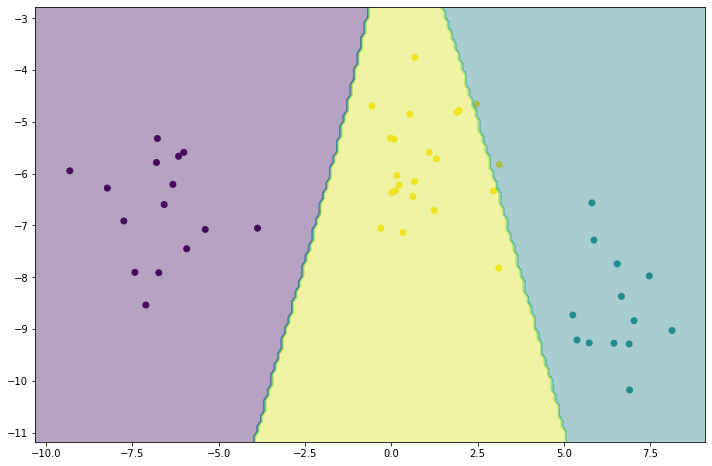

In [514]:
draw_boundary(model, x_test, y_test, one_hot=True)

## PyTorch

In [516]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn import datasets
from torch.utils.data import TensorDataset, DataLoader

# prepare the data
x, y = datasets.make_blobs(n_samples=300, centers=3)
x_train, x_test = torch.tensor(x[:250]).float(), torch.tensor(x[250:]).float()
y_train, y_test = torch.tensor(y[:250]), torch.tensor(y[250:])

# Create DataLoader for batching
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# set the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 3)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        
        x = torch.sigmoid(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x
    
    def predict(self, x):
        return self.forward(x).detach()

model = Net()

# set the optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# train the network
for epoch in range(200):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

# predict some of the instances
with torch.no_grad():
    predictions = model(x_test[:10])
    print(predictions)

tensor([[0.0534, 0.0469, 0.8996],
        [0.3533, 0.5295, 0.1172],
        [0.6287, 0.2849, 0.0864],
        [0.0466, 0.0517, 0.9016],
        [0.0519, 0.0606, 0.8876],
        [0.3736, 0.4901, 0.1363],
        [0.5924, 0.3159, 0.0916],
        [0.0561, 0.0472, 0.8967],
        [0.0592, 0.0520, 0.8888],
        [0.3525, 0.5174, 0.1301]])


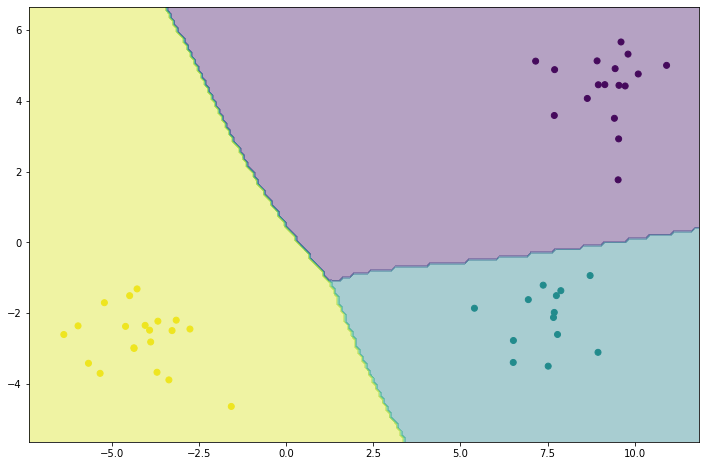

In [517]:
draw_boundary(model, x_test, y_test, one_hot=True)

## Prehistorie

Ve většině případů pravděpodobně budete používat TensorFlow na podobné úrovni jako výše, tj. budete vytvářet modely z existujících modulů. Ale pojďme se rychle podívat trochu hlouběji na to, jak TensorFlow funguje.

TensorFlow je vlastně knihovna pro symbolické výpočty. V ní můžeme definovat výpočet (výraz), který vyhodnotíme později. Z hlediska neuronových sítí je důležité, že TensorFlow dokáže také vypočítat gradient z tohoto výrazu a obsahuje také řadu optimalizátorů.

Existují tři hlavní typy "proměnných" v TensorFlow - Placeholder se používá pro vstupy (když ho chceme později vyhodnotit, musíme jim přiřadit hodnotu), Constant se používá pro konstanty a Variable se používá pro proměnné, které je možné trénovat. Ukázka vytváření jednoduchého výrazu, který počítá lineární model typu $b + \sum_{i=1}^3 w_i x_i$, je níže. Zde je $x$ zástupný symbol a hodnotu nezískává až později. Kromě toho také počítáme MSE na základě $y$, takže máme připravený model pro lineární regresi, který se může naučit předpovídat $y$ na základě $x$.

Příklady níže používají staré rozhraní TensorFlow v1, které obsahovalo řadu nízkoúrovňových funkcí. Některé z nich byly v TensorFlow 2 přesunuty nebo odstraněny. Jedná se o funkce začínající tf.compat.v1.

In [477]:
import pprint
# create training data and print them
x_train = np.random.uniform(0, 1, size=(100, 3))
y_train = np.dot(x_train, np.array([2,3,1])) + 1
pprint.pprint(list(zip(x_train, y_train))[:10])

[(array([0.90961834, 0.36348222, 0.32312044]), 4.232803778262452),
 (array([0.98463323, 0.80120451, 0.04892947]), 5.42180946424037),
 (array([0.81790606, 0.39356847, 0.54400189]), 4.360519430887939),
 (array([0.5390394 , 0.67994321, 0.19214731]), 4.310055725604071),
 (array([0.9587994 , 0.35213615, 0.36596639]), 4.33997364206863),
 (array([0.63965266, 0.71036764, 0.63515725]), 5.045565499886573),
 (array([0.71594299, 0.41279119, 0.27362679]), 3.9438863259337213),
 (array([0.36206936, 0.53379941, 0.12929164]), 3.4548285980838402),
 (array([0.30902533, 0.88120356, 0.62441369]), 4.886075039655831),
 (array([0.92826446, 0.73372919, 0.75192248]), 5.809638972311806)]


In [478]:
# remove the previous model
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

# define the model inputs
# None in shape means that this dimension will be defined later - typically it is used for the training/testing data,
# where we do not know how many instance we will get, only one dimension can be None
x = tf.compat.v1.placeholder(tf.float32, shape=(None, 3))
y = tf.compat.v1.placeholder(tf.float32, shape=(None,))

# define the trainable variables, we need to specify initial values for them
w = tf.Variable(tf.compat.v1.random_uniform(shape=(3,)))
b = tf.Variable(tf.compat.v1.random_uniform(shape=(1,)))
# and we can use the variables to define the output of the model
z = tf.tensordot(x, w, 1) + b

# define the loss function
loss = tf.reduce_mean(tf.compat.v1.squared_difference(z, y))

# before we can evaluate the model, we must set the variables initializer
init = tf.compat.v1.global_variables_initializer()

# if we want to train the model, we need to set up the optimizer - it will use the loss function defined above

optim = tf.compat.v1.train.GradientDescentOptimizer(0.1).minimize(loss)

# tensorflow can also compute gradients
grad = tf.gradients(loss, xs=[w,b])    

# all computations in tensorflow run in a Session
with tf.compat.v1.Session() as sess:
    # if we want to evaluate something, we use Session.run()
    sess.run(init)  # initialize the variables
    
    # we can print the values of the variables (we need to call run to compute the values)
    print('w:', sess.run(w))
    print('b:', sess.run(b))
    # we can specify the values of placeholders with feed-dict
    print('z:', sess.run(z, feed_dict={x: [[1,1,1]]}))
    
    print('loss:', sess.run(loss, feed_dict={x: x_train, y:y_train}))
    # tensorflow can compute the gradients
    wg,bg = sess.run(grad, feed_dict={x: x_train, y:y_train})
    print('wg:', wg)
    print('bg:', bg)
    # one call to optim runs one step of gradient descend
    for k in range(10):
        for i in range(100):
            sess.run(optim, feed_dict={x: x_train, y:y_train})
        print(f'epoch {100*(k+1)}: loss ', sess.run(loss, feed_dict={x: x_train, y:y_train}))
    # we can also print the values to check the result
    print('w:', sess.run(w))
    print('b:', sess.run(b))
    
    # we can also implement the optimization manually using the gradient descend algorithm
    print('='*50)
    
    sess.run(init)
    print('w:', sess.run(w))
    print('b:', sess.run(b))
    
    # let us define the operations from the gradient descend algorithm, we need to define them outside of the loop,
    # otherwise they would be added to the computation loop mutliple times and slow the computation down considerably
    # NOT THIS: sess.run([w.assign_sub(0.1*wg), b.assign_sub(0.1*bg)], feed_dict={x: x_train, y:y_train})
    wg, bg = grad
    w_update=w.assign_sub(0.1*wg)
    b_update=b.assign_sub(0.1*bg)
    
    for k in range(10):
        for i in range(100):
            # session.run can evaluate mutliple expressions at the same time
            sess.run([w_update, b_update], feed_dict={x: x_train, y:y_train})
        print(f'epoch {100*(k+1)}: loss ', sess.run(loss, feed_dict={x: x_train, y:y_train}))
    
    # let't print the values of the parameters again
    w_, b_ = sess.run([w,b])
    print('w:', w_)
    print('b:', b_)

w: [0.50769186 0.27478802 0.57420015]
b: [0.34215343]
z: [1.6988335]
loss: 9.918565
wg: [-3.3024445 -3.5148163 -3.176413 ]
bg: [-6.0465913]
epoch 100: loss  0.024413984
epoch 200: loss  0.0038171648
epoch 300: loss  0.000689273
epoch 400: loss  0.00012664146
epoch 500: loss  2.3337263e-05
epoch 600: loss  4.3033606e-06
epoch 700: loss  7.9386996e-07
epoch 800: loss  1.4648374e-07
epoch 900: loss  2.7043916e-08
epoch 1000: loss  5.0175237e-09
w: [1.9998548 2.999839  0.9998682]
b: [1.0002344]
w: [0.34560132 0.01568472 0.22930336]
b: [0.41676784]
epoch 100: loss  0.034172278
epoch 200: loss  0.005700025
epoch 300: loss  0.0010401972
epoch 400: loss  0.00019156787
epoch 500: loss  3.5324094e-05
epoch 600: loss  6.5144804e-06
epoch 700: loss  1.2016063e-06
epoch 800: loss  2.2159372e-07
epoch 900: loss  4.0908972e-08
epoch 1000: loss  7.571952e-09
w: [1.9998219 2.999802  0.9998379]
b: [1.0002879]
